# Set up run

In [1]:
#-- Set up configurations / parameters
retrain = False # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
n_batch = 15
n_epochs = 30
n_test = 500
ratio = 727 # penalization ratio for GL and non-GL points based on smaller dataaset
mod_lbl = 'atrous' #'unet'
if mod_lbl == 'unet':
  mod_str = '{0}_{1}init_{2}down_drop{3:.1f}_customLossR{4}'.format(mod_lbl,ninit,ndown,
                                                        dropout_frac,ratio)
elif mod_lbl == 'atrous':
  mod_str = '{0}_{1}init_drop{2:.1f}_customLossR{3}'.format(mod_lbl,ninit,dropout_frac,ratio)
else:
  print('model label not matching.')
print(mod_str)

atrous_32init_drop0.2_customLossR727


In [2]:
#-- Import Modules
import os
import imp
import random
import numpy as np
import matplotlib.pyplot as plt 
from google.colab import drive
import keras
from keras import backend as K
from keras.preprocessing import image
from tensorflow.python.client import device_lib
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
#-- Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#-- Directory setup
colabdir = '/content/gdrive/My Drive/Colab Notebooks/'
output_dir = '/content/gdrive/My Drive/GL_Learning/'
ddir = '/content/gdrive/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/geocoded_v1/'
train_dir = os.path.join(ddir,'train_n%i.dir'%n_test)
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)

In [0]:
#-- Get list of images
fileList = os.listdir(train_dir)
train_list = [f for f in fileList if (f.endswith('.npy') and f.startswith('coco'))]
fileList = os.listdir(test_dir)
test_list = [f for f in fileList if (f.endswith('.npy') and f.startswith('coco'))]

In [6]:
#-- set ID_list to be passed onto data generator class
ID_list = [os.path.join(train_dir,f) for f in train_list]
N = len(ID_list)
print(N)

#-- read 1 file to get dimensions
im = np.load(ID_list[0])
h,wi,ch = im.shape
print(h,wi,ch)

#-- randomly set aside 10% of data for validation
valid_ii = random.sample(range(N),int(0.1*N))
train_ii = np.setdiff1d(np.arange(N),valid_ii)

5320
512 512 2


In [7]:
#-- NOTE: we need to install rasterio so that it can be used by the
#--  data generator in the next cell
!pip install rasterio

     |████████████████████████████████| 18.1MB 199kB/s 


In [0]:
#-- setup generator
data_generation = imp.load_source('data_generation',os.path.join(colabdir,'data_generation.py'))
from data_generation import DataGenerator
training_generator = DataGenerator(list(np.array(ID_list)[train_ii]),batch_size=n_batch, dim=(h,wi), 
	n_channels=ch, shuffle=True)
validation_generator = DataGenerator(list(np.array(ID_list)[valid_ii]),batch_size=n_batch, dim=(h,wi), 
	n_channels=ch, shuffle=True)

In [9]:
#-- Import model
mod_module = imp.load_source('nn_model',os.path.join(colabdir,'nn_model.py'))
#-- set up model
if mod_lbl == 'unet':
  print('loading unet model')
  model = mod_module.unet_model_double_dropout(height=h,width=wi,channels=ch, 
                                        n_init=ninit,n_layers=ndown,
                                        drop=dropout_frac)
elif mod_lbl == 'atrous':
  print("loading atrous model")
  model = mod_module.nn_model_atrous_double_dropout(height=h,width=wi,
                                                channels=ch,
                                                n_filts=ninit,
                                                drop=dropout_frac)
else:
  print('Model label not correct.')

loading atrous model


In [0]:
#-- define custom loss function
def customLoss(yTrue,yPred):
  return -1*K.mean(ratio*(yTrue*K.log(yPred+1e-32)) + ((1. - yTrue)*K.log(1-yPred+1e-32)))

In [0]:
#-- compile imported model
model.compile(loss=customLoss,optimizer='adam',
              metrics=['accuracy'])

In [12]:
#-- checkpoint file
chk_file = os.path.join(output_dir,'{0}_weights.h5'.format(mod_str))

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  print('Model does not previously exist.')

Check point exists; loading model from file.


In [0]:
#-- Train the model
if (retrain) or (not os.path.isfile(chk_file)):
  print('Training model...')
  #-- create checkpoint
  model_checkpoint = keras.callbacks.ModelCheckpoint(chk_file, monitor='loss',
                                                     verbose=1, 
                                                     save_best_only=True)
  lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                                  verbose=1, mode='auto', min_delta=0.0001, 
                                  cooldown=0, min_lr=0)
  es_callback = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=5,
     verbose=1, mode='auto')
  #-- now fit the model
  history = model.fit_generator(generator=training_generator,
                                validation_data=validation_generator,
                                use_multiprocessing=True,
                                workers=8, epochs=n_epochs,
                                shuffle=True, verbose=1,
                                callbacks=[lr_callback,es_callback,model_checkpoint])

In [0]:
#-- save model if it fails
#model.save(chk_file,overwrite=True)

In [15]:
"""
#-- save history to file
  outfile = open(os.path.join(output_dir,
                        '{0}_history.txt'
                        .format(mod_str)),'w')
  outfile.write('Epoch loss\tval_loss\tacc\tval_acc\n')
  for i in range(len(history.history['loss'])):
      outfile.write('%i\t%f\t%f\t%f\t%f\n'%(i,history.history['loss'][i],history.history['val_loss'][i],\
          history.history['accuracy'][i],history.history['val_accuracy'][i]))
  outfile.close()

  #-- Make plots for training history
  for item,name in zip(['accuracy','loss'],['Accuracy','Loss']):
    fig = plt.figure(1,figsize=(8,6))
    plt.plot(history.history[item])
    plt.plot(history.history['val_%s'%item])
    plt.title('Model %s'%name)
    plt.ylabel(name)
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(output_dir,
                        '{0}_history.pdf'
                        .format(mod_str)),format='pdf')
    plt.close(fig)
"""

"\n#-- save history to file\n  outfile = open(os.path.join(output_dir,\n                        '{0}_history.txt'\n                        .format(mod_str)),'w')\n  outfile.write('Epoch loss\tval_loss\tacc\tval_acc\n')\n  for i in range(len(history.history['loss'])):\n      outfile.write('%i\t%f\t%f\t%f\t%f\n'%(i,history.history['loss'][i],history.history['val_loss'][i],          history.history['accuracy'][i],history.history['val_accuracy'][i]))\n  outfile.close()\n\n  #-- Make plots for training history\n  for item,name in zip(['accuracy','loss'],['Accuracy','Loss']):\n    fig = plt.figure(1,figsize=(8,6))\n    plt.plot(history.history[item])\n    plt.plot(history.history['val_%s'%item])\n    plt.title('Model %s'%name)\n    plt.ylabel(name)\n    plt.xlabel('Epochs')\n    plt.legend(['Training', 'Validation'], loc='upper left')\n    plt.savefig(os.path.join(output_dir,\n                        '{0}_history.pdf'\n                        .format(mod_str)),format='pdf')\n    plt.close(fi

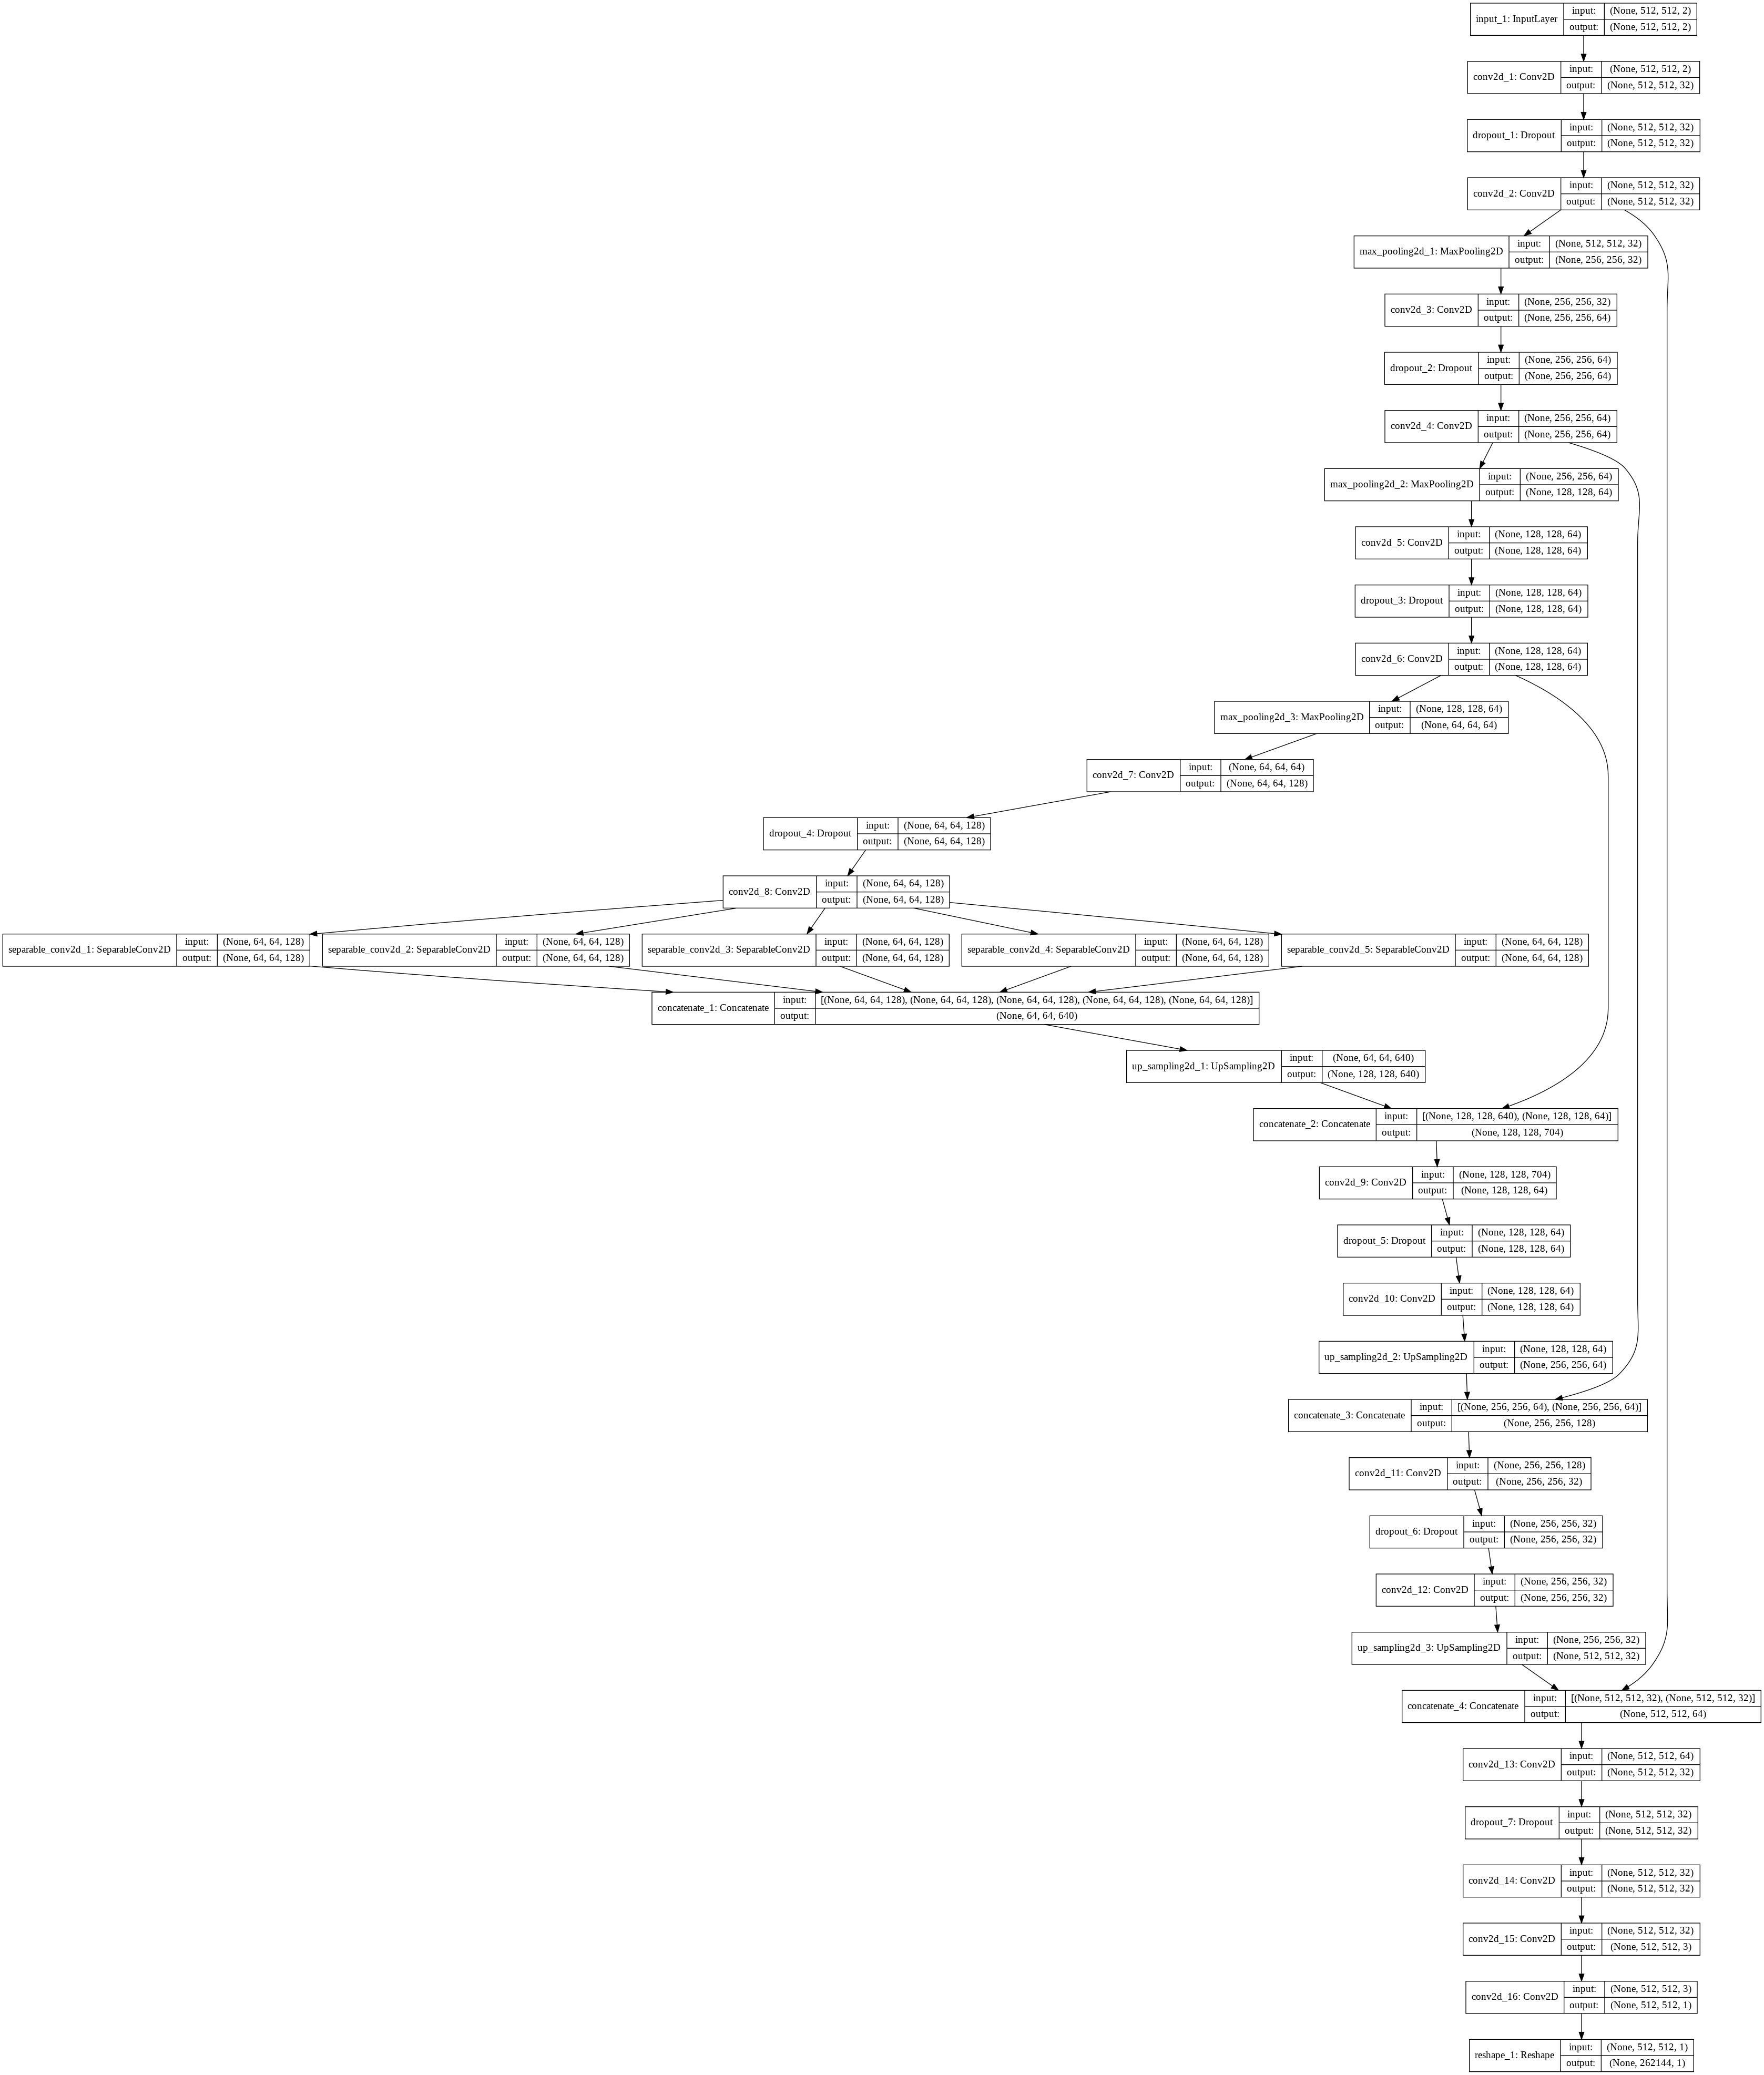

In [16]:
#-- plot and save model diagaram
plot_model(model,to_file=os.path.join(output_dir,'{0}_diagram.png'.format(mod_str)),show_shapes=True)

In [17]:
print('Model is trained. Running on Train data...')
#-------------------------------
#-- First run on training data
#-------------------------------
#-- make output directory
out_dir = os.path.join(output_dir,'Train_predictions.dir',
                       '{0}.dir'.format(mod_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)
# Read the images 500 at a time to save memory
idx = 0 #-- index count
incr = 500 #- reading increment
while idx < len(train_list):
  in_imgs = np.empty((incr,h,w,ch))
  for i,f enumerate(train_list[idx:idx+incr]):
    in_imgs[i,] = np.load(os.path.join(train_dir,f)) 
  out_imgs = model.predict(in_imgs, batch_size=1, verbose=1)
  out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])

  #-- save output images
  for i,f enumerate(train_list[idx:idx+incr]):
    im = image.array_to_img(out_imgs[i]) 
    im.save(os.path.join(out_dir,f.replace('coco','pred').replace('npy','png')))
  
  #-- increment index count
  idx += incr

"\nprint('Model is trained. Running on Train data...')\n#-------------------------------\n#-- First run on training data\n#-------------------------------\n#-- make output directory\nout_dir = os.path.join(output_dir,'Train_predictions.dir',\n                       '{0}.dir'.format(mod_str))\nif (not os.path.isdir(out_dir)):\n  os.mkdir(out_dir)\n# Read the images 500 at a time to save memory\nidx = 0 #-- index count\nincr = 500 #- reading increment\nwhile idx + inc <= len(train_list):\n  in_imgs = np.empty((incr,h,w,ch))\n  for i,f enumerate(train_list[idx:idx+incr]):\n    in_imgs[i,] = np.load(os.path.join(train_dir,f)) \n  out_imgs = model.predict(in_imgs, batch_size=1, verbose=1)\n  out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])\n\n  #-- save output images\n  for i,f enumerate(train_list[idx:idx+incr]):\n    im = image.array_to_img(out_imgs[i]) \n    im.save(os.path.join(out_dir,f.replace('coco','pred').replace('npy','png')))\n  \n  #-- increment index count\

In [0]:
#-- Read test data all at once
test_imgs = np.ones((n_test,h,wi,ch))
for i,f in enumerate(test_list):
    test_imgs[i,] = np.load(os.path.join(test_dir,f))

In [19]:
#-------------------------------
#-- Run on test data
#-------------------------------
out_imgs = model.predict(test_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(output_dir,'Test_predictions.dir',
                       '{0}.dir'.format(mod_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images
for i,f in enumerate(test_list):
  im = image.array_to_img(out_imgs[i]) 
  im.save(os.path.join(out_dir,f.replace('coco','pred').replace('npy','png')))

500/500 [==============================] - 33s 65ms/step
(500, 512, 512, 1)


In [20]:
print(np.max(out_imgs))
print(np.min(out_imgs))

0.99913496
0.0026668415
